In [87]:
import pandas as pd
import numpy as np
import os
import requests
import matplotlib.pyplot as plt
from scipy import interpolate
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
import random
import time
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score



This analysis is done on Jan 30, 2022. Since we are in between GW23, only data up to GW22 is considered for this analysis.

## Dataset Preparation 

<b> DO NOT execute these cells if you are working with the same dataset. Rather move to the next section to import the locally saved copy.

### Overall Gameweek Performance

The first step is to gather information around the overall population performance of individual gameweeks.

In [2]:
url1 = 'https://fantasy.premierleague.com/api/bootstrap-static/'
r1 = requests.get(url1)
generalinfo = r1.json()
generalinfo.keys()

# Gameweek population performance

events_df = pd.DataFrame(generalinfo['events'])
events_df_1 = events_df[['id','average_entry_score','most_selected','most_transferred_in',
                         'top_element','top_element_info','most_captained','highest_score']]
events_df_1.columns = ['gw','average_entry_score','most_selected','most_transferred_in',
                       'top_element','top_element_info','most_captained','highest_score']
events_df_2 = events_df_1[['gw','average_entry_score','highest_score']]

# club information

teams_df = pd.DataFrame(generalinfo['teams'])
teams_df_1 = teams_df[['id','name']]
teams_df_1.columns = ['team_id','team_name']

The events dataframe contains the average score and the highest score of a certain gameweek.

### Sampling 20 User Performance

In [4]:
id_list = []

for i in range(20):
    id_list.append(int(np.random.uniform(1,8000000)))

In [6]:
#id_list

In [25]:
def player_info(ids):
    url2 = "https://fantasy.premierleague.com/api/entry/" + str(ids) + "/history/"
    r2 = requests.get(url2)
    managerhistory = r2.json()
    managerhistory.keys()

    # Extracting the player specific information
    history_df = pd.DataFrame(managerhistory['current'])
    history_df.columns = ['gw','points', 'total_points', 'rank', 'rank_sort', 'overall_rank',
                          'bank', 'value', 'event_transfers', 'event_transfers_cost',
                          'points_on_bench']
    history_df_1 = history_df[['gw','points','total_points','rank','overall_rank','value']]
    history_df_1['user_id'] = ids
    
    # Merging with the overall dataset
    history_df_2 = pd.merge(history_df_1, events_df_2, 
                        left_on=['gw'],right_on=['gw'],
                        how='left')
    
    # calculate points above average 
    history_df_2['points_above_avg']=history_df_2['points']-history_df_2['average_entry_score']
    history_df_2['points_above_avg_percent'] = history_df_2['points_above_avg']/history_df_2['average_entry_score']
    history_df_2['points_above_avg_percent'] = history_df_2['points_above_avg_percent'].round(2)
    
    # find the rank change
    history_df_2['rank_change'] = history_df_2['overall_rank'].diff()*(-1)

    history_df_2['rank_change'] = history_df_2['rank_change'].fillna(8000000-1676988)
    history_df_2['rank_change'] = history_df_2['rank_change'].astype(int)

    history_df_2['previous_rank'] = history_df_2['overall_rank'].shift(1)
    history_df_2['previous_rank'] = history_df_2['previous_rank'].fillna(8000000)

    history_df_2['rank_change_percent'] = history_df_2['rank_change']/history_df_2['previous_rank']
    history_df_2['rank_change_percent'] = history_df_2['rank_change_percent'].round(2)
    
    return history_df_2

In [26]:
data = pd.DataFrame(columns=['gw','points','total_points','rank','overall_rank','value',
                             'user_id','average_entry_score','highest_score','points_above_avg',
                             'points_above_avg_percent','rank_change','previous_rank','rank_change_percent'])

In [27]:
for i in range(20):
    
    df1 = player_info(id_list[i])
    data = data.append(df1)
    
    wait_time = random.randrange(7,12)
    time.sleep(wait_time)
    
    del df1
    print(i+1)

<ipython-input-25-ce31e1af617a>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  history_df_1['user_id'] = ids


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20


In [119]:
data.to_csv('20users_dataset_GW22_01312022.csv')

## Import dataset  

In [120]:
#data = read.csv('20users_dataset_GW22_01312022.csv')

In [28]:
data.shape

(458, 14)

In [32]:
data.head(2)

,gw,points,total_points,rank,overall_rank,value,user_id,average_entry_score,highest_score,points_above_avg,points_above_avg_percent,rank_change,previous_rank,rank_change_percent
0,2,80,80,359599,6071313,1003,7142029,56,146.0,24,0.43,6323012,8000000.0,0.79
1,3,50,130,4873118,5926329,1005,7142029,54,119.0,-4,-0.07,144984,6071313.0,0.02


### Data Exploration

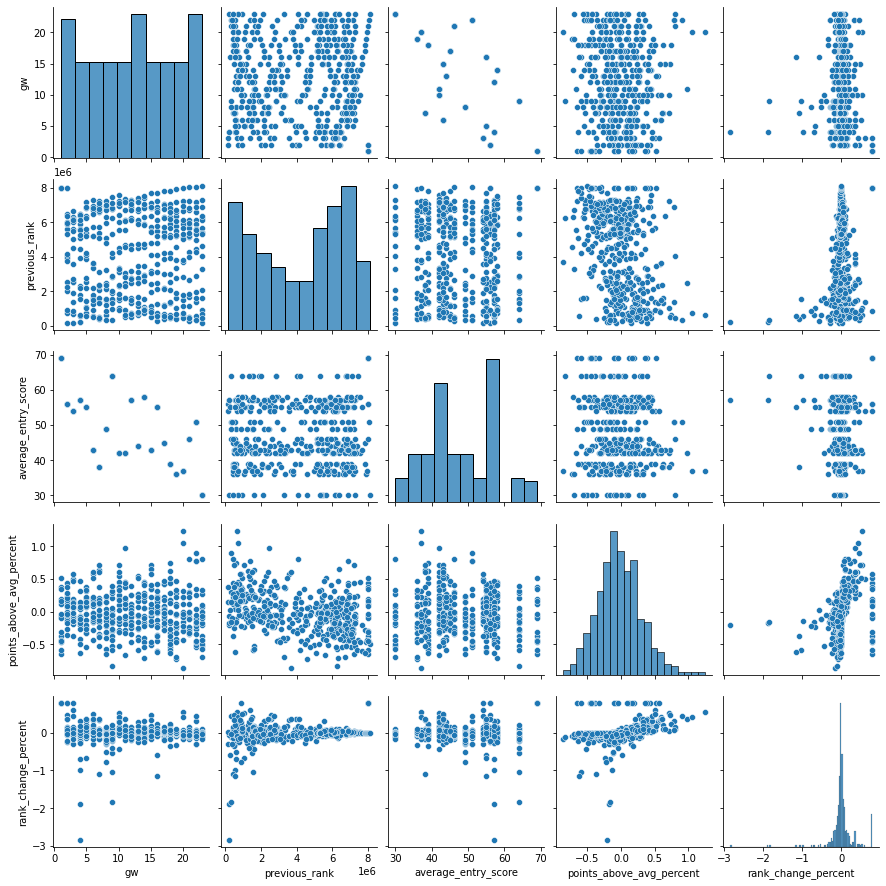

In [35]:
# without regression
sns.pairplot(data[['gw','previous_rank','average_entry_score',
                   'points_above_avg_percent','rank_change_percent']], kind="scatter")
plt.show()

In [37]:
data[(data['rank_change_percent']<-1)]

,gw,points,total_points,rank,overall_rank,value,user_id,average_entry_score,highest_score,points_above_avg,points_above_avg_percent,rank_change,previous_rank,rank_change_percent
3,4,45,285,6660800,730902,1012,496052,57,120.0,-12,-0.21,-540587,190315.0,-2.84
3,4,47,291,6196226,547395,1007,5655111,57,120.0,-10,-0.18,-357080,190315.0,-1.88
6,7,24,430,7405641,866869,1014,5655111,38,102.0,-14,-0.37,-450868,416001.0,-1.08
8,9,26,490,8026039,3119979,1011,5655111,64,165.0,-38,-0.59,-1586288,1533691.0,-1.03
8,9,54,566,5513411,881322,1012,718727,64,165.0,-10,-0.16,-570637,310685.0,-1.84
15,16,21,932,8637080,1159547,1010,718727,55,128.0,-34,-0.62,-620896,538651.0,-1.15


In [38]:
data[(data['user_id']==496052)]

,gw,points,total_points,rank,overall_rank,value,user_id,average_entry_score,highest_score,points_above_avg,points_above_avg_percent,rank_change,previous_rank,rank_change_percent
0,1,105,105,151567,151566,1000,496052,69,150.0,36,0.52,6323012,8000000.0,0.79
1,2,77,182,604313,146410,1005,496052,56,146.0,21,0.38,5156,151566.0,0.03
2,3,62,244,2186764,190315,1011,496052,54,119.0,8,0.15,-43905,146410.0,-0.30
3,4,45,285,6660800,730902,1012,496052,57,120.0,-12,-0.21,-540587,190315.0,-2.84
4,5,66,351,1553339,577465,1012,496052,55,144.0,11,0.20,153437,730902.0,0.21
5,6,50,401,2061730,524458,1016,496052,43,117.0,7,0.16,53007,577465.0,0.09
6,7,43,440,2710713,619993,1018,496052,38,102.0,5,0.13,-95535,524458.0,-0.18
7,8,43,483,5637385,940035,1021,496052,49,122.0,-6,-0.12,-320042,619993.0,-0.52
8,9,77,560,2833197,1027745,1021,496052,64,165.0,13,0.20,-87710,940035.0,-0.09
9,10,72,632,111147,478918,1020,496052,42,116.0,30,0.71,548827,1027745.0,0.53


There are cases of rank change percentage being over 100 or -100%. When the denominator is small, this could happen. 

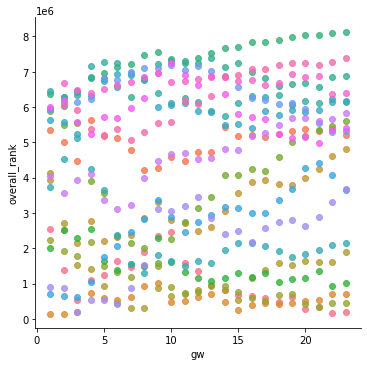

In [113]:
# Use the 'hue' argument to provide a factor variable
sns.lmplot(x="gw", y="overall_rank", data=data, fit_reg=False, hue='user_id', legend=False)
 
plt.show()

### Model To Predict Rank Change %

In [81]:
#data[(data['gw']!=23)]

In [41]:
Y = data[(data['gw']!=23)]['rank_change_percent']
X = data[(data['gw']!=23)][['gw','points_above_avg_percent','average_entry_score','previous_rank']]

In [109]:
X.dtypes

gw                           object
points_above_avg_percent    float64
average_entry_score          object
previous_rank               float64
dtype: object

In [63]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.6, random_state=20)

In [75]:
X_train_const = sm.add_constant(X_train)

<b> MODEL 1

In [76]:
model1 = sm.OLS(Y_train, X_train_const.astype(float)).fit()
model1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     rank_change_percent   R-squared:                       0.293
Model:                             OLS   Adj. R-squared:                  0.276
Method:                  Least Squares   F-statistic:                     17.61
Date:                 Sun, 30 Jan 2022   Prob (F-statistic):           4.13e-12
Time:                         22:01:04   Log-Likelihood:                -27.950
No. Observations:                  175   AIC:                             65.90
Df Residuals:                      170   BIC:                             81.72
Df Model:                            4                                         
Covariance Type:             nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                       -0.1816      0.166     -1.092      0.276      -0.510       0.147
gw                          -0.0001      0.004     -0.028      0.977      -0.008       0.008
points_above_avg_percent     0.5598      0.075      7.506      0.000       0.413       0.707
average_entry_score         -0.0010      0.003     -0.329      0.743      -0.007       0.005
previous_rank              5.58e-08   9.72e-09      5.741      0.000    3.66e-08     7.5e-08
==============================================================================
Omnibus:                      210.969   Durbin-Watson:                   1.880
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            10672.501
Skew:                          -4.668   Prob(JB):                         0.00
Kurtosis:                      40.101   Cond. No.                     3.54e+07
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.54e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

<b> MODEL 2

In [79]:
X_train_const_2 = X_train_const[['const','points_above_avg_percent','previous_rank']]

In [80]:
model2 = sm.OLS(Y_train, X_train_const_2.astype(float)).fit()
model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     rank_change_percent   R-squared:                       0.292
Model:                             OLS   Adj. R-squared:                  0.284
Method:                  Least Squares   F-statistic:                     35.55
Date:                 Mon, 31 Jan 2022   Prob (F-statistic):           1.20e-13
Time:                         10:43:57   Log-Likelihood:                -28.011
No. Observations:                  175   AIC:                             62.02
Df Residuals:                      172   BIC:                             71.52
Df Model:                            2                                         
Covariance Type:             nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                       -0.2277      0.043     -5.235      0.000      -0.314      -0.142
points_above_avg_percent     0.5623      0.074      7.648      0.000       0.417       0.707
previous_rank              5.53e-08   9.55e-09      5.789      0.000    3.64e-08    7.42e-08
==============================================================================
Omnibus:                      212.902   Durbin-Watson:                   1.878
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            10964.014
Skew:                          -4.735   Prob(JB):                         0.00
Kurtosis:                      40.602   Cond. No.                     1.60e+07
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.6e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

It seems that 'points_above_avg_percent' and 'previous_rank' significant correlate and affect the 'rank_change_percent' we are trying to model here. 

<b> Testing MODEL 2

In [ ]:
Y_pred = m2.predict(X_const)

x = np.linspace(-0.5,0.9,100)
y = x

plt.scatter(Y_pred, Y1)
plt.plot(y, x, '-r', label='ideal line')
plt.xlabel('Predictions')
plt.ylabel('Actual')
plt.title('Actual vs Prediction')
plt.legend(loc='upper left')
plt.show()

In [82]:
X_test_const = sm.add_constant(X_test)
X_test_const_2 = X_test_const[['const','points_above_avg_percent','previous_rank']]

Y_pred = model2.predict(X_test_const_2)

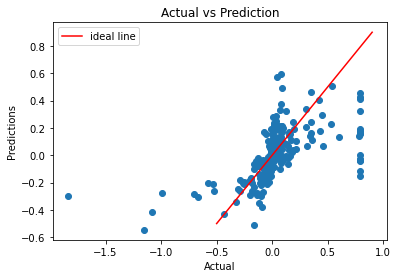

0.3224686891414462

In [89]:
x = np.linspace(-0.5,0.9,100)
y = x

plt.scatter(Y_test, Y_pred)
plt.plot(x, y, '-r', label='ideal line')
plt.xlabel('Actual')
plt.ylabel('Predictions')
plt.title('Actual vs Prediction')
plt.legend(loc='upper left')
plt.show()

r2_score(Y_test, Y_pred)

R-squared is better than the training set's R^2. But the fit is not great. Need to explore the underlying functional form of this use case.

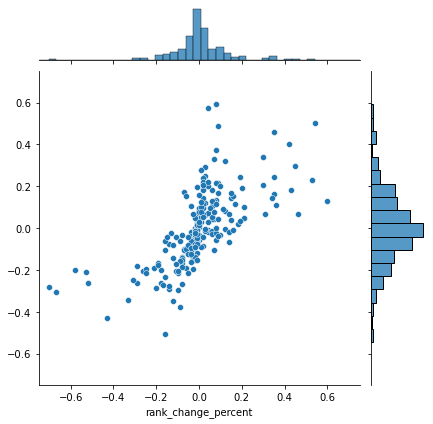

In [99]:
plot = sns.jointplot(x=Y_test, y=Y_pred, kind='scatter')
plot.ax_marg_x.set_xlim(-0.75,0.75)
plot.ax_marg_y.set_ylim(-0.75,0.75)

plt.show()